#### Last Modified: Feb 23rd, 2022 (Opal). 

## sOpInf on MHD (MAS Code) Solar Wind Radial Speed Dataset


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM2


In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
import numpy as np 

import time
import astropy.units as u

In [3]:
os.chdir(os.getcwd() + "/code/")
from numerical_methods import apply_numerical_method
from hux_propagation import apply_hux_f_model
os.chdir("../")

In [4]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

### Import MHD solar wind velocity results.

In [5]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [6]:
# read in MHD velocity results. 
vr_model = model['vr']

In [7]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
n = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [8]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [9]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [10]:
V = np.array(f[:, 55, :])

In [11]:
V_HUX = apply_hux_f_model(f[:, 55, 0], (r[1:]-r[:-1]).to(u.km).value, p[1:] -p[:-1]).T

In [12]:
V_HUX.shape

(129, 140)

### Background: Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [13]:
def plot_heat_data(Z, title, sample_columns=np.append(np.arange(0, len(r), 20),len(r) -1), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(variable + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=500, bbox_inches='tight')

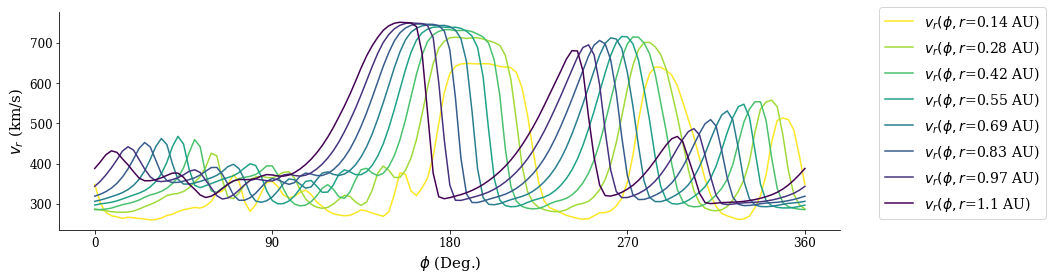

In [14]:
plot_heat_data(V, "", variable=r"$v_{r}$", save_fig=True, file_name="MHD/figs/CR"+ str(cr) +"/original_dataset_MHD.png")

In [15]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [16]:
v1 = V[:, 0]
shift_vec = [0]
for ii in range(1, len(r)):
    v2 = V[:, ii]
    corr = periodic_corr_np(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    shift_vec.append(p[np.argmax(corr)]*180/np.pi)

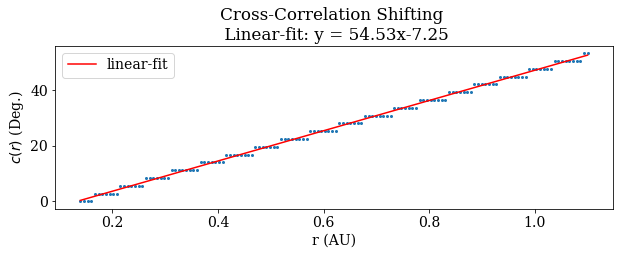

In [17]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), shift_vec, s=4)

n = int(len(r)*0.7)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")
_ = ax.legend()
_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: y = " + str(round(m, 2)) + "x" + str(round(b, 2)))

In [18]:
def shift_function(r, m, b):
    return m * r + b

In [19]:
V_new = np.zeros((len(p), len(r)))

V_new[:, 0] = V[:, 0]

for jj in range(1, len(r)):
    # interpolate on the current eulerian grid. 
    f_interp = interp1d(p*180/np.pi, V[:, jj], fill_value="extrapolate", bounds_error=False)
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # define the new shifted coordinate.
    x_new = (p*180/np.pi - shift) % (360)
    # interpolate over the shifted coordinate
    V_new[:, jj] = f_interp(x_new)

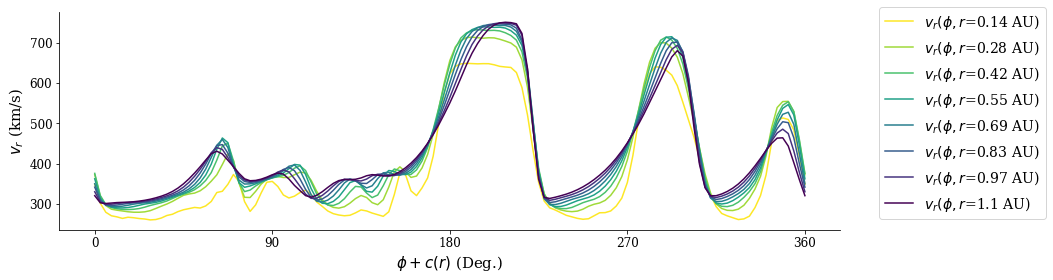

In [20]:
plot_heat_data(V_new, "", variable=r"$v_{r}$", xlabel=r"$\phi + c(r)$ (Deg.)", 
              save_fig=True, file_name="MHD/figs/CR"+ str(cr) +"/shifted_dataset_MHD.png")

### Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [21]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [22]:
X= V_new

In [23]:
V_new.shape

(129, 140)

In [24]:
X_train = V_new[:, :l]
X_test = V_new[:, l:]

In [25]:
r_train = r[:l]
r_test = r[l:]

In [26]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


### Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

## Using the ROM Operator Inference Package

### Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [27]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(V[:, :l])

In [28]:
# Calculate the cumulative energy.
thresh = .996
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 9
r (Eularian coordinates)= 15


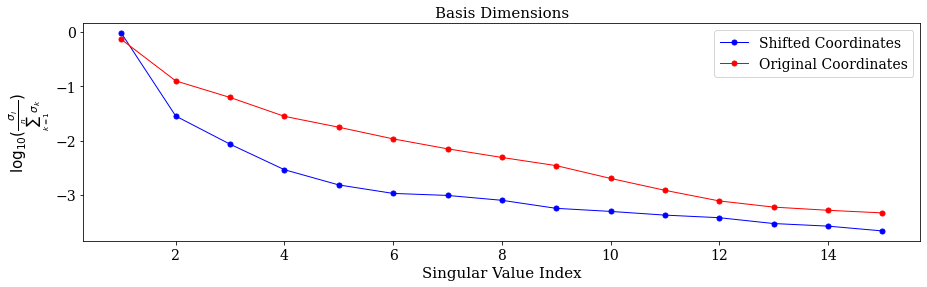

In [29]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), np.log10(svdvals[:15]/ np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), np.log10(svdvals_prev[:15]/ np.sum(svdvals_prev)), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")


plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}})$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

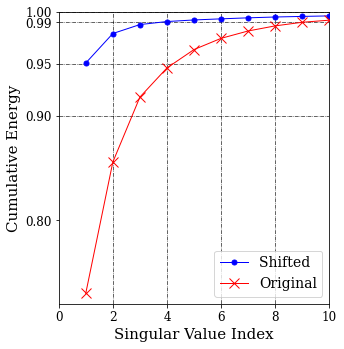

In [30]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(5, 5))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted ")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original")
# get current y-limits 
ylim = ax.get_ylim()

# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")


ax.vlines(2, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(4, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(6, 0, 1, color="black", linewidth=.6, linestyle="-.")
ax.vlines(8, 0, 1, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
ax.set_ylim(0.72, 1)
plt.savefig("MHD/figs/CR2210/singular_value_decay_MAS_equator.png", pad_inches=1)

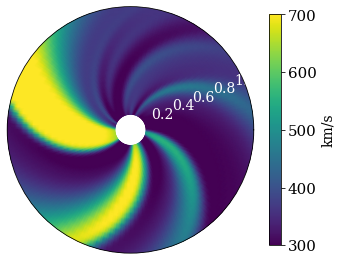

In [31]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, V.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("MHD/figs/MAS_polar_original.png", dpi=600)

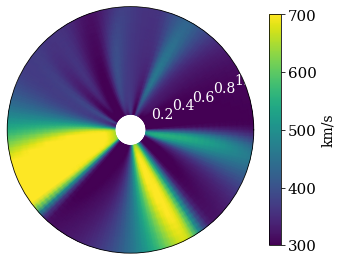

In [32]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})

ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, V_new.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax), orientation="vertical", shrink=0.7)
cbar.ax.set_ylabel(r'km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig("MHD/figs/MAS_polar_shifted.png", dpi=600)

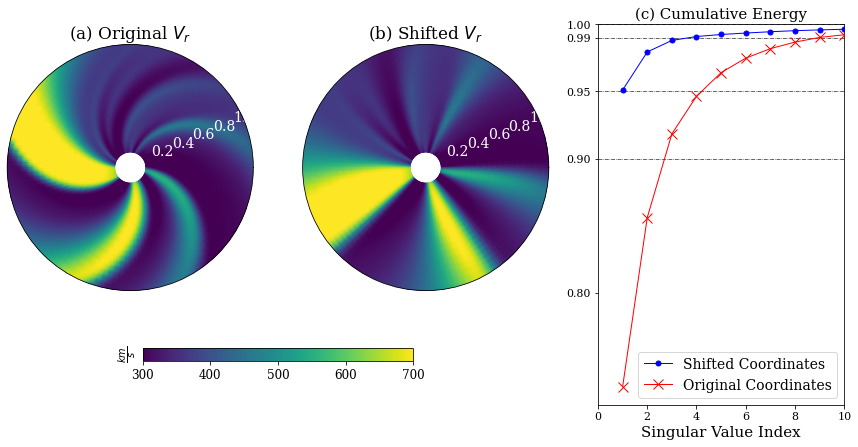

In [33]:
fig=plt.figure(figsize=(15, 7))
ax = fig.add_subplot(131, polar=True)
ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, V.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")
ax.set_title("(a) Original $V_{r}$")
ax1 = fig.add_subplot(132, polar=True)
ax1.set_rlim(0)
ax1.set_thetalim(0, 2 * np.pi)
ax1.set_xticks([])

ax1.set_ylim(0,1.1)
rlabels = ax1.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax1.pcolormesh(p, r.to(u.AU).value, V_new.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax1, ax), orientation="horizontal", shrink=0.5)
cbar.ax.set_ylabel(r'$\frac{km}{s}$', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)
_ = ax1.set_title("(b) Shifted $V_{r}$")

ax = fig.add_subplot(133)

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ax.set_ylim(top=1)
ylim = ax.get_ylim()

# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
#_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("(c) Cumulative Energy", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=11)


plt.savefig("MHD/figs/1D_MHD_shifted-comparison.png", dpi=600)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [34]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (129, 9)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

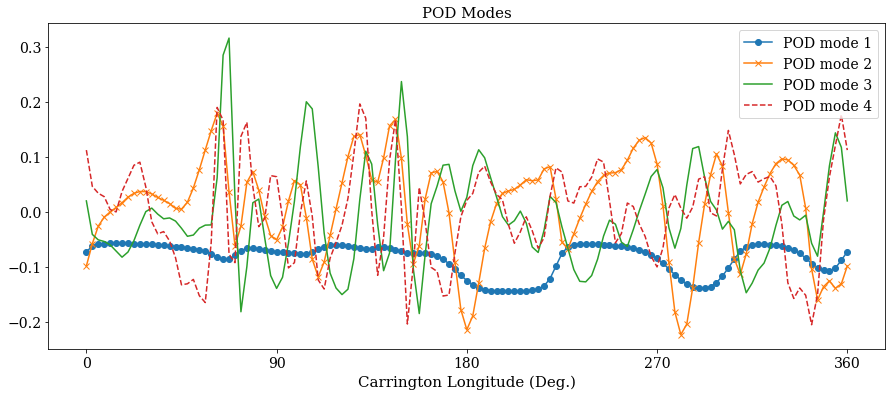

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot((180/np.pi) * p, Vr[:len(p),0], "-o", label=f"POD mode {1}")
ax.plot((180/np.pi) * p, Vr[:len(p),1], "-x", label=f"POD mode {2}")
ax.plot((180/np.pi) * p, Vr[:len(p),2], "-", label=f"POD mode {3}")
ax.plot((180/np.pi) * p, Vr[:len(p),3], "--", label=f"POD mode {4}")
#ax.plot((180/np.pi) * p_new, Vr[:len(p_new),4], "-", label=f"POD mode {5}")


    
ax.set_xlabel("Carrington Longitude (Deg.)", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
plt.legend(loc="upper right")
plt.show()

In [36]:
roi.pre.projection_error(X_train, Vr)

0.001044518842007735

### Model Form (Linear) $\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t)$

we seek a reduced model of the form 
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$

but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Esentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind proton velocity at several heliocentric distances. 


In [37]:
X_ = Vr.T @ X_train                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (r[1]-r[0]).value, order = 6) # Estimate the projected time derivatives.

In [38]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


In [39]:
model.fit(Vr, X_train, Xdot_, P=1e2)

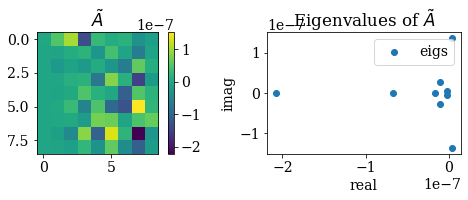

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)

_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [41]:
X_ROM = model.predict(X[:, 0], r.value, method="BDF")
X_ROM.shape

(129, 140)

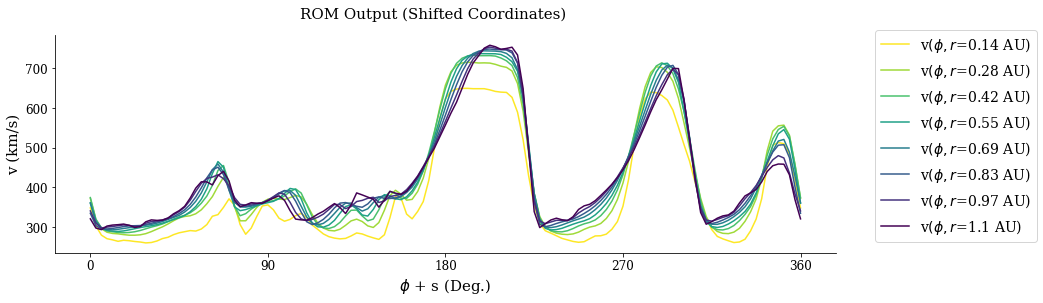

In [42]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel=r"$\phi$ + s (Deg.)")

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

In [43]:
def convert_from_x_to_v(X_ROM):
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    for jj in range(1, len(r)):
        # interp on eulerian corrdinates. 
        f_interp = interp1d(p, X_ROM[:, jj], fill_value="extrapolate", bounds_error=False)
        # find shift based on linear fit.
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # shifted coordinates.
        x_new = (p + shift*np.pi/180) % (2*np.pi)
        # interpolate over shifted coords. 
        V_ROM[:, jj] = f_interp(x_new)
    return V_ROM

In [44]:
V_ROM = convert_from_x_to_v(X_ROM)

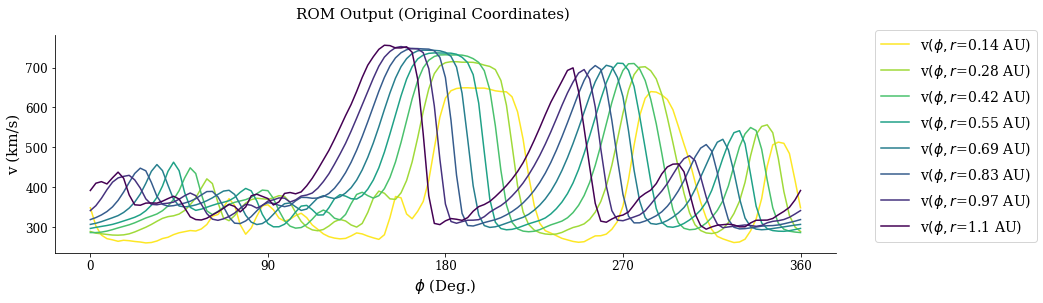

In [45]:
plot_heat_data(V_ROM, "ROM Output (Original Coordinates)", variable="v")

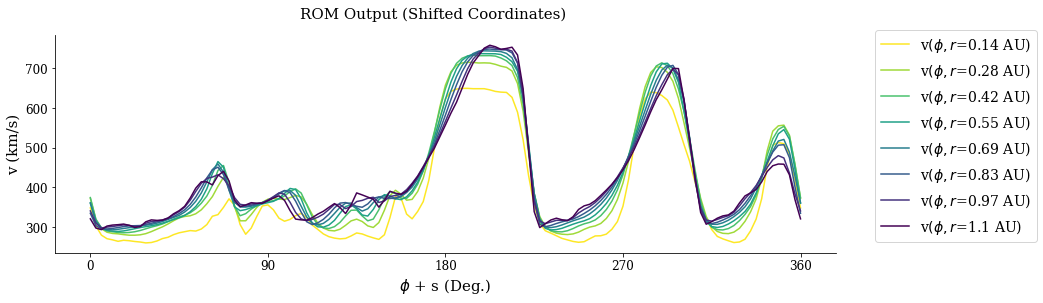

In [46]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel=r"$\phi$ + s (Deg.)")

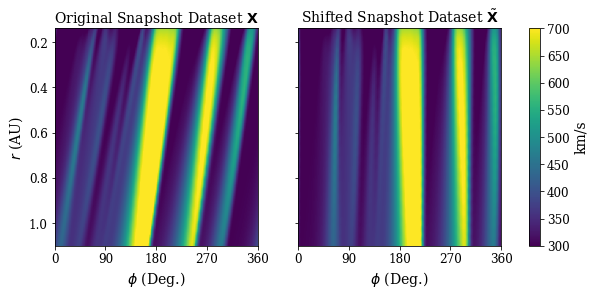

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
pos = ax[0].imshow(V.T, extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], aspect="auto", vmin=300, vmax=700)
_ = ax[0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
_ = ax[0].set_ylabel(r"$r$ (AU)", fontsize=14)
_ = ax[0].set_xticks([0, 90, 180, 270, 360])
_ = ax[1].set_title("Shifted Snapshot Dataset " + r"$\tilde{\mathbf{X}}$", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)


pos = ax[1].imshow(X.T, extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], aspect="auto", vmin=300, vmax=700)
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)
_ = ax[1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
_ = ax[1].set_xticks([0, 90, 180, 270, 360])
_ = ax[0].set_title("Original Snapshot Dataset " + r"$\mathbf{X}$", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)


#plt.savefig("figs/equator_velocity_profile_shifted_and_original.png", bbox_inches="tight", dpi=800)

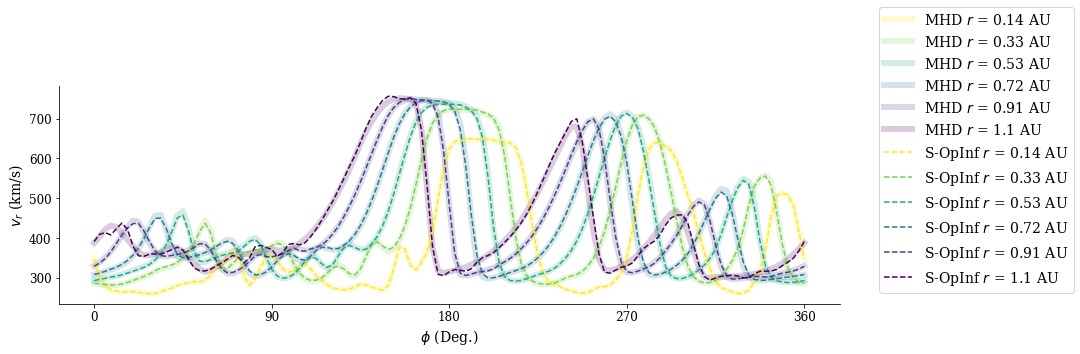

In [48]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"MHD $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=r"S-OpInf $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=14)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v_{r}$ (km/s)", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("MHD/figs/CR2210/A/shifted_opinf_results_mhd_A_1D.png", dpi=500, bbox_inches='tight')


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

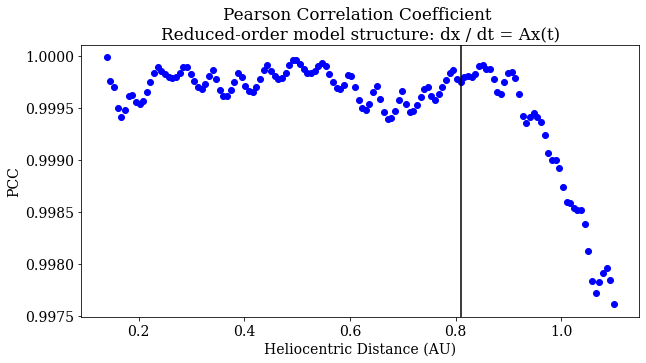

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient \n" + str(model))

plt.savefig("MHD/figs/CR2210/A/pcc_sopinf_mhd.png")

In [50]:
print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM[:, :l]))[0])
print("2d pcc testing = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM[:, l:]))[0])

print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))

print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))

2d pcc training =  0.999688607526074
2d pcc testing =  0.9990378312294412
Training RE (mean) % 0.5797621605715153
Training RE (median) % 0.3487348713750908
Training RE (max) % 6.787218013279634
Testing RE (mean) % 0.8604775262538333
Testing RE (median) % 0.47680074986002335
Testing RE (max) % 9.120459829762824


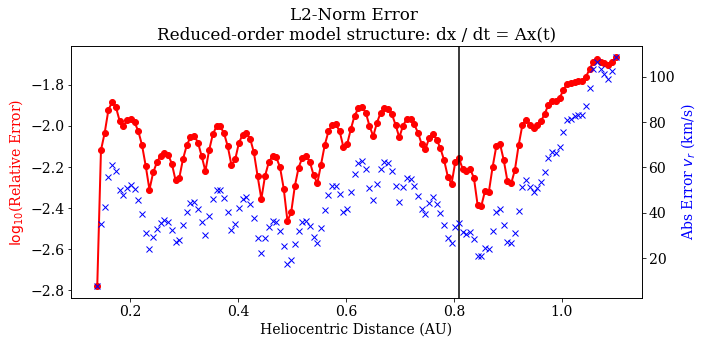

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errA),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error \n" + str(model))
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errA, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/A/L2_error_operator_inference_mhd.png", dpi=300)

In [52]:
abs_froerr, rel_froerr = roi.post.frobenius_error(V, V_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 1.010047%


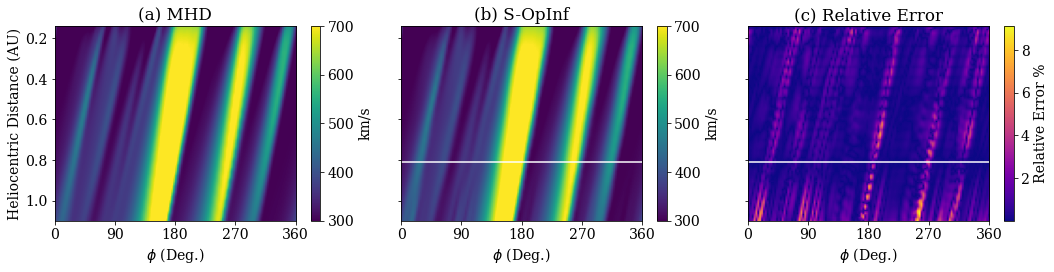

In [53]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360,r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"Heliocentric Distance (AU)")
ax[0].set_title("(a) MHD")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r[-1].to(u.AU).value, 
                                    r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) S-OpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("(c) Relative Error")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)



plt.tight_layout()
plt.savefig("MHD/figs/CR2210/A/Relative_Error_MHD_A_1D.png", dpi=600)

In [54]:
print("mean relative error = ", np.mean(np.abs((V- V_ROM))/np.abs(V)))

print("min relative error = ", np.min(np.abs((V- V_ROM))/np.abs(V)))

print("max relative error = ", np.max(np.abs((V- V_ROM))/np.abs(V)))

mean relative error =  0.006639767702762108
min relative error =  1.4958015766851602e-06
max relative error =  0.09120459829762824


### Streamlines Comparison MHD vs. HUX vs. S-OpInf

In [55]:
def compute_phi_shift_forward(p, r, v, omega=2*np.pi/25.38, method=None):
    # initialize phi shift matrix. 
    phi_shift_mat = np.zeros((len(r), len(p)))
    
    # phi at index 0 is original phi grid 
    phi_shift_mat[0, :] = p
    
    # delta r.
    dr = np.mean(r[1:] - r[:-1])
    
    # compute the phi shift for each idx in r. 
    for ii in range(len(r)-1):
        if method == "ballistic":
            phi_shift = -(omega/v[:, 0])*dr
        else:
            phi_shift = -(omega/v[:, ii])*dr
        phi_shift_mat[ii+1, :] = phi_shift_mat[ii, :] + phi_shift
        
    return phi_shift_mat 

In [56]:
def cmap():
    # an array of parameters, each of our curves depend on a specific value of parameters.
    parameters = np.linspace(0,2*np.pi,len(p))
    # norm is a class which, when called, can normalize data into the [0.0, 1.0] interval.
    norm = matplotlib.colors.Normalize(vmin=np.min(parameters), vmax=np.max(parameters))
    # create a ScalarMappable and initialize a data structure
    arr = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.hsv, norm=norm)
    arr.set_array([])
    return arr

In [57]:
def cdf(data, ax, label, ls):
    data_size=len(data)
    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts=counts.astype(float)/data_size
    # Find the cdf
    cdf = np.cumsum(counts)
    # Plot the cdf
    ax.plot(bin_edges[:-1], cdf, ls=ls, label=label)

In [58]:
U_MHD = (V*u.km/u.second).to(u.AU/u.day).value
U_HUX = (V_HUX*u.km/u.second).to(u.AU/u.day).value
U_OpInf = (V_ROM*u.km/u.second).to(u.AU/u.day).value

phi_shift_mhd = compute_phi_shift_forward(p, r.to(u.AU).value, U_MHD)
phi_shift_hux = compute_phi_shift_forward(p, r.to(u.AU).value, U_HUX)
phi_shift_sopinf = compute_phi_shift_forward(p, r.to(u.AU).value, U_OpInf)

(HUX) mu =  2.186938867280373
(HUX) sigma =  1.4632554719893223
(S-OpInf) mu =  0.10582238966314154
(S-OpInf) sigma =  0.08136676281559502


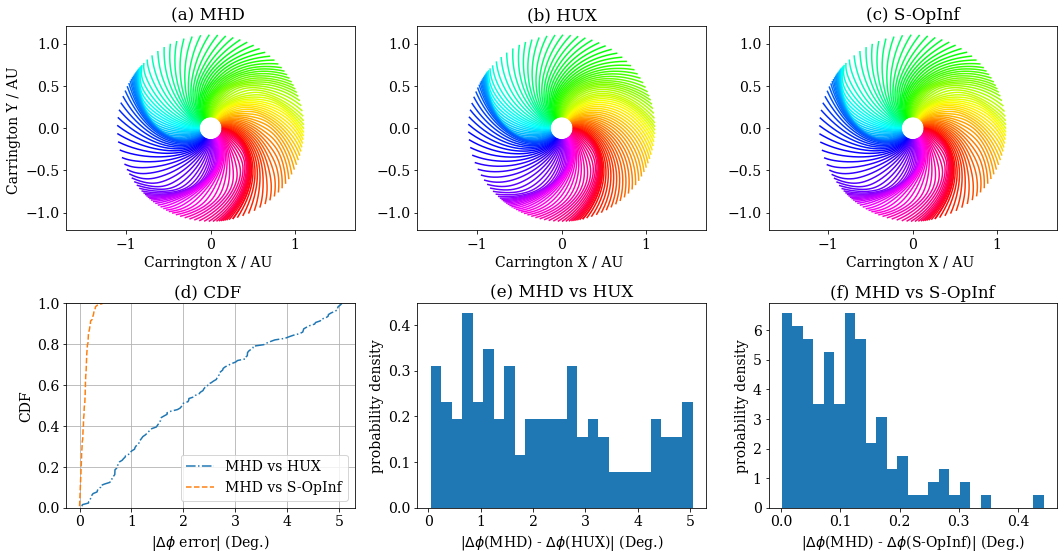

In [59]:
s_m = cmap()

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))
for ii in range(len(p)):
    _ = ax[0, 0].plot(np.cos(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 1].plot(np.cos(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 2].plot(np.cos(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    
_ = ax[0, 0].set_title("(a) MHD ")
_ = ax[0, 0].set_xlabel("Carrington X / AU ")
_ = ax[0, 0].set_ylabel("Carrington Y / AU ")
_ = ax[0, 0].axis("equal")

_ = ax[0, 1].set_title("(b) HUX")
_ = ax[0, 1].set_xlabel("Carrington X / AU ")
_ = ax[0, 1].axis("equal")

_ = ax[0, 2].set_title("(c) S-OpInf")
_ = ax[0, 2].set_xlabel("Carrington X / AU ")
_ = ax[0, 2].axis("equal")

diff_hux = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_hux[-1])
mu, sigma = stats.norm.fit(diff_hux)
print("(HUX) mu = ", mu )
print("(HUX) sigma = ", sigma )
n , bins, _ = ax[1, 1].hist(np.abs(diff_hux), 25, density=1)

_ = ax[1, 1].set_title("(e) MHD vs HUX")
_ = ax[1, 1].set_xlabel("$|\Delta \phi$(MHD) - $\Delta \phi$(HUX)| (Deg.)")
_ = ax[1, 1].set_ylabel("probability density") 



diff_rom = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_sopinf[-1])
mu, sigma = stats.norm.fit(diff_rom)
print("(S-OpInf) mu = ", mu )
print("(S-OpInf) sigma = ", sigma )
n , bins, _ = ax[1, 2].hist(np.abs(diff_rom), 25, density=1)

_ = ax[1, 2].set_title("(f) MHD vs S-OpInf")
_ = ax[1, 2].set_xlabel("$|\Delta \phi$(MHD) - $\Delta \phi$(S-OpInf)| (Deg.)")
_ = ax[1, 2].set_ylabel("probability density") 


cdf(diff_hux, ax[1, 0], label = "MHD vs HUX", ls="-.")
cdf(diff_rom, ax[1, 0], label = "MHD vs S-OpInf", ls="--")
ax[1, 0].set_ylim((0,1))
ax[1, 0].set_ylabel("CDF")
ax[1, 0].set_xlabel("|$\Delta \phi$ error| (Deg.)")
ax[1, 0].grid(True)
ax[1, 0].set_title("(d) CDF ")
_ = ax[1, 0].legend()

plt.tight_layout()
plt.savefig('MHD/figs/MHD_HUX_OpInf_streamlines.png')

### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [60]:
coeff_array = 10**np.linspace(1, 6, 20)
rank_array = np.arange(3, 10)

training_error = np.ones((len(coeff_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff_array), len(rank_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    for ii, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
        Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6) 
        model = roi.InferredContinuousROM(modelform="A")            
        model.fit(Vr, X_train, Xdot, P=coeff)                          
        X_ROM = model.predict(X[:, 0], r.value, method="BDF", 
                              max_step=(r_train[1] - r_train[0]).value) 
        
        if np.shape(X_ROM) == np.shape(V):
            V_ROM = convert_from_x_to_v(X_ROM)
            # save
            training_error[kk, ii] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
            # save
            testing_error[kk, ii] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

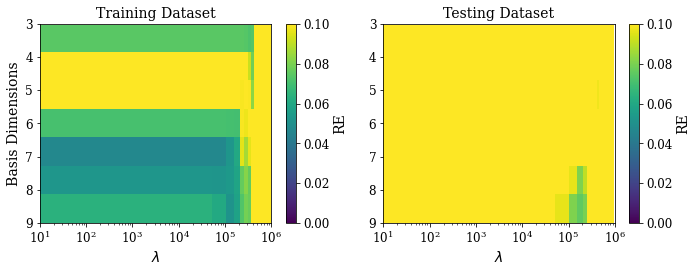

In [61]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].imshow(training_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0, vmax=0.1, aspect="auto")


_ = ax[0].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[0].set_ylabel(r"Basis Dimensions", fontsize=14)
_ = ax[0].set_title("Training Dataset", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('RE', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].imshow(testing_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0, vmax=0.1,   aspect="auto")


_ = ax[1].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[1].set_title("Testing Dataset", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('RE', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")

plt.tight_layout()

In [62]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Training rank =",  rank_array[idx[1]])

Training lambda = 1.263157894736842
Training rank = 7


In [63]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array[idx[1]])
print("Error =",  testing_error[idx[0], idx[1]])

Testing lambda = 1.7894736842105263
Testing rank = 9
Error = 0.07541635696141254


### Quadratic ROM $\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{H}(\hat{\mathbf{x}}(t) \otimes \hat{\mathbf{x}}(t))$

In [64]:
# Calculate the cumulative energy.
thresh = .996

cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 9


In [65]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=5e5)                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

In [66]:
V_ROM = convert_from_x_to_v(X_ROM)

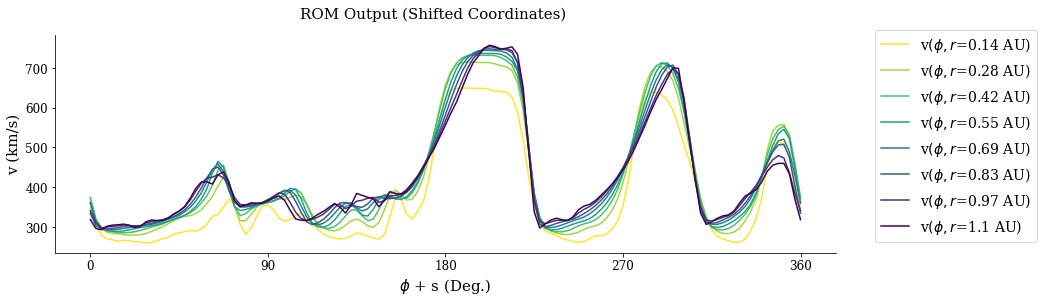

In [67]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel="$\phi$ + s (Deg.)")

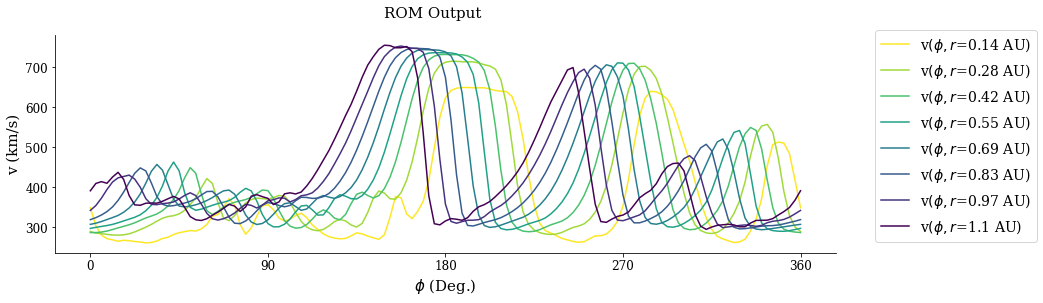

In [68]:
plot_heat_data(V_ROM, "ROM Output", variable="v")

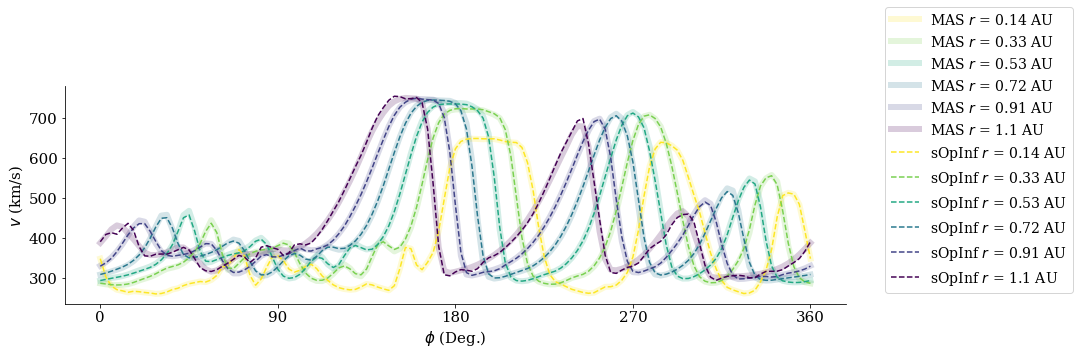

In [69]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"MAS $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=rf"sOpInf $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=15)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=15)

fig.savefig("MHD/figs/CR" + str(cr) + "/H/sopinf_vs_MAS_H.png", dpi=500, bbox_inches='tight')

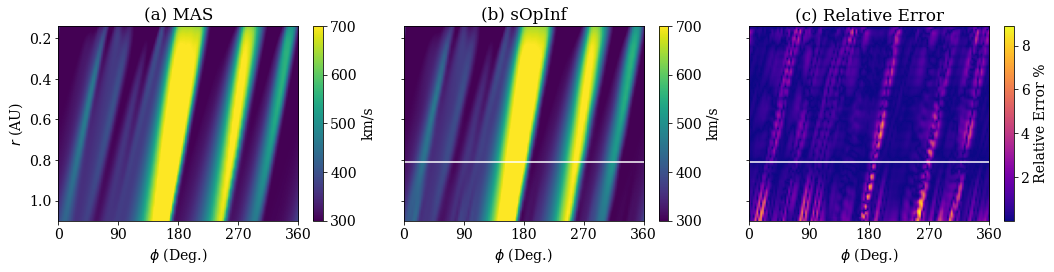

In [70]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360, r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r $ (AU)")
ax[0].set_title("(a) MAS")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360, r[-1].to(u.AU).value, 
                                    r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) sOpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM.T - V.T)/np.abs(V.T), extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].set_title("(c) Relative Error")
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)

plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/sopinf_vs_MAS_H_2dprofile.png", dpi=500, bbox_inches='tight')

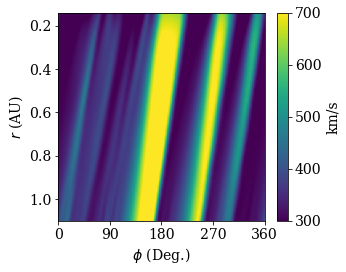

In [71]:
fig, ax = plt.subplots(figsize=(5, 4))

pos = ax.imshow(V_ROM.T, extent=[0,360, r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax.set_xlabel(r"$\phi$ (Deg.)")
ax.set_ylabel(r"$r $ (AU)")
ax.set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('km/s', rotation=90)

plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/MAS_equator", dpi=500, bbox_inches='tight')

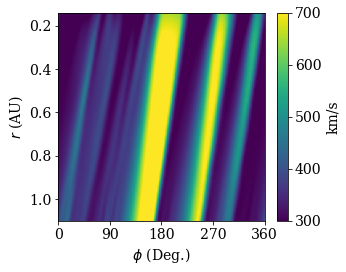

In [72]:
fig, ax = plt.subplots(figsize=(5, 4))

pos = ax.imshow(V_ROM.T, extent=[0,360, r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax.set_xlabel(r"$\phi$ (Deg.)")
ax.set_ylabel(r"$r $ (AU)")
ax.set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('km/s', rotation=90)

plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/sOpInf_equator", dpi=500, bbox_inches='tight')

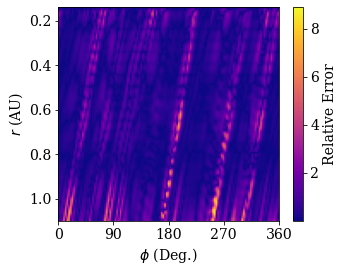

In [73]:
fig, ax = plt.subplots(figsize=(5, 4))

pos = ax.imshow(100*np.abs(V_ROM.T - V.T)/np.abs(V.T), extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax.set_xlabel(r"$\phi$ (Deg.)")
ax.set_ylabel(r"$r $ (AU)")
ax.set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/H/RE_equator", dpi=500, bbox_inches='tight')

In [74]:
print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :l] - V_ROM[:, :l])/np.abs(V[:, :l])))

Training RE (mean) % 0.5853194008275407
Training RE (median) % 0.35116406144018053
Training RE (max) % 6.845361725857018


In [75]:
print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, l:] - V_ROM[:, l:])/np.abs(V[:, l:])))

Testing RE (mean) % 0.8748314774768969
Testing RE (median) % 0.48338549684742715
Testing RE (max) % 8.894818672982568


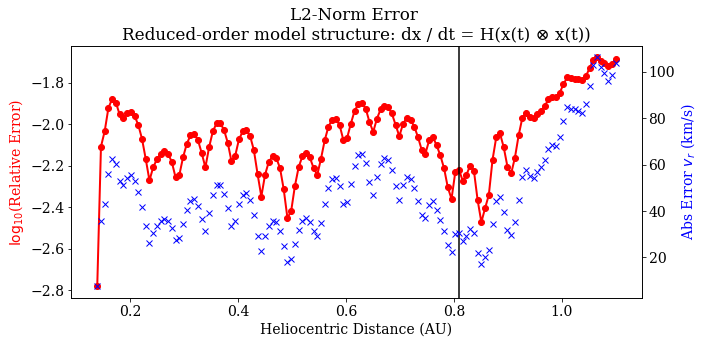

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errH),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error \n" + str(model))
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errH, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

plt.savefig("MHD/figs/CR2210/H/L2_error_operator_inference_mhd_H.png", dpi=300)

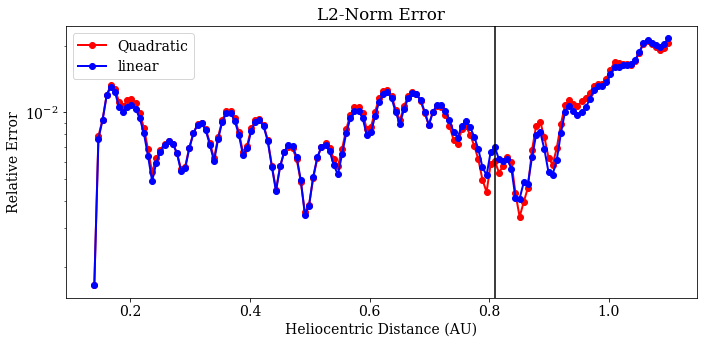

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))


_ = ax.plot(r.to(u.AU).value, rel_l2errH,"-o", linewidth=2, c="r", label="Quadratic")
_ = ax.plot(r.to(u.AU).value, rel_l2errA,"-o", linewidth=2, c="b", label="linear")

_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error")
_ = ax.set_ylabel("Relative Error", c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.yscale("log")
plt.tight_layout()
plt.legend()

#plt.savefig("figs/L2_error_operator_inference_mhd_A_vs_H.png", dpi=300)

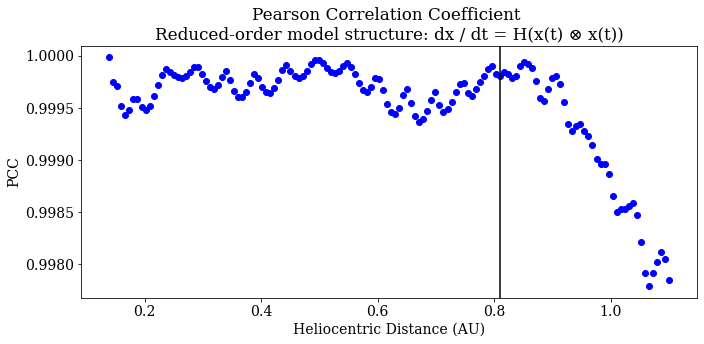

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient \n" + str(model))

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/H/pcc_shifted_operator_inference_mhd.png", dpi=300)

In [79]:
print("2d pcc = ", stats.pearsonr(np.ndarray.flatten(V), np.ndarray.flatten(V_ROM))[0])

print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM[:, :l]))[0])

print("2d pcc testing = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM[:, l:]))[0])

2d pcc =  0.9994766296897186
2d pcc training =  0.9996786789666077
2d pcc testing =  0.9990129868063079


### Streamlines Comparison MHD vs. HUX vs. sOpInf

In [80]:
U_MHD = (V*u.km/u.second).to(u.AU/u.day).value
U_HUX = (V_HUX*u.km/u.second).to(u.AU/u.day).value
U_OpInf = (V_ROM*u.km/u.second).to(u.AU/u.day).value

phi_shift_mhd = compute_phi_shift_forward(p, r.to(u.AU).value, U_MHD)
phi_shift_hux = compute_phi_shift_forward(p, r.to(u.AU).value, U_HUX)
phi_shift_sopinf = compute_phi_shift_forward(p, r.to(u.AU).value, U_OpInf)

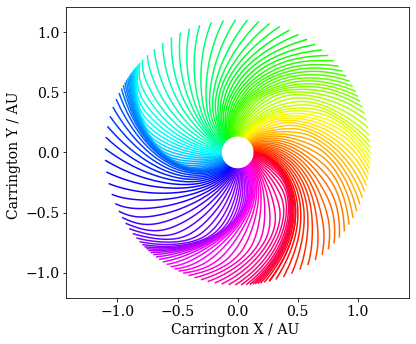

In [81]:
fig, ax = plt.subplots(figsize=(6, 5))
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))

_ = ax.set_xlabel("Carrington X / AU ")
_ = ax.set_ylabel("Carrington Y / AU ")
_ = ax.axis("equal")


plt.tight_layout()
plt.savefig("MHD/figs/CR2210/MAS_streamlines.png")

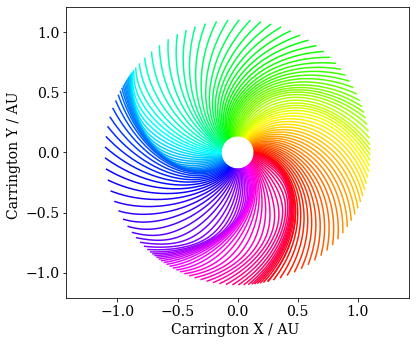

In [82]:
fig, ax = plt.subplots(figsize=(6, 5))
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))

_ = ax.set_xlabel("Carrington X / AU ")
_ = ax.set_ylabel("Carrington Y / AU ")
_ = ax.axis("equal")

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/HUX_streamlines.png")

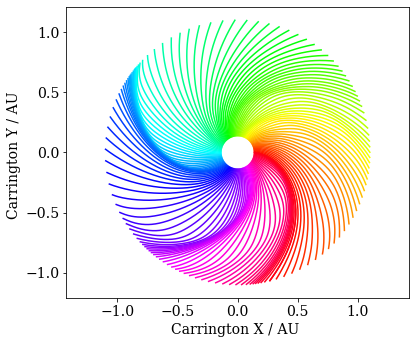

In [83]:
fig, ax = plt.subplots(figsize=(6, 5))
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))

_ = ax.set_xlabel("Carrington X / AU ")
_ = ax.set_ylabel("Carrington Y / AU ")
_ = ax.axis("equal")

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/sOpInf_streamlines.png")

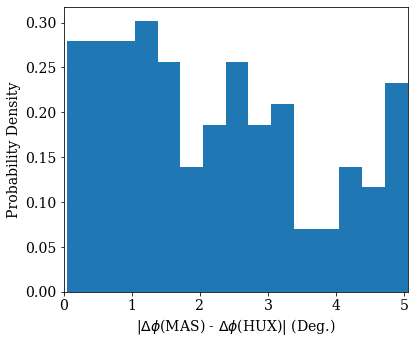

In [84]:
fig, ax = plt.subplots(figsize=(6, 5))
diff_hux = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_hux[-1])
mu, sigma = stats.norm.fit(diff_hux)
n , bins, _ = ax.hist(np.abs(diff_hux), 15, density=1)
_ = ax.set_xlim(left=0, right=np.max(np.abs(diff_hux)))
#_ = ax.set_title("(e) HUX vs. MAS")
_ = ax.set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(HUX)| (Deg.)")
_ = ax.set_ylabel("Probability Density") 

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/HUX_vs_MAS_streamlines.png")

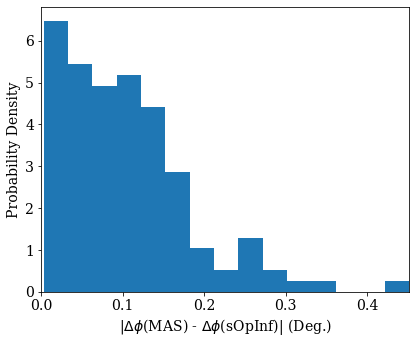

In [85]:
fig, ax = plt.subplots(figsize=(6, 5))
diff_rom = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_sopinf[-1])
mu, sigma = stats.norm.fit(diff_rom)
n , bins, _ = ax.hist(np.abs(diff_rom), 15, density=1)
_ = ax.set_xlim(left=0, right=np.max(np.abs(diff_rom)))
_ = ax.set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(sOpInf)| (Deg.)")
_ = ax.set_ylabel("Probability Density") 

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/sOpInf_vs_MAS_streamlines.png")

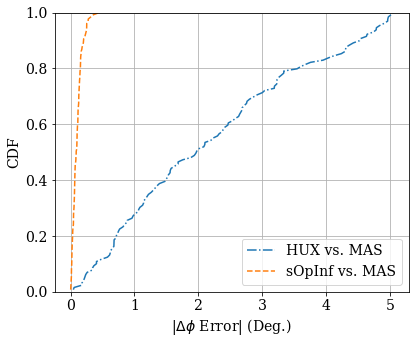

In [86]:
fig, ax = plt.subplots(figsize=(6, 5))


cdf(diff_hux, ax, label = "HUX vs. MAS", ls="-.")
cdf(diff_rom, ax, label = "sOpInf vs. MAS", ls="--")
ax.set_ylim((0,1))
ax.set_ylabel("CDF")
ax.set_xlabel("|$\Delta \phi$ Error| (Deg.)")
ax.grid(True)
_ = ax.legend()

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/cdf_streamlines.png")

(HUX) mu =  2.186938867280373
(HUX) median =  1.9777172999028183
(HUX) max. =  5.047840212839434
(HUX) sigma =  1.4632554719893223
(sOpInf) mu =  0.10373450339638118
(sOpInf) sigma =  0.07870209604387265
(sOpInf) median =  0.08966010157433285
(sOpInf) max. =  0.4513813843801475


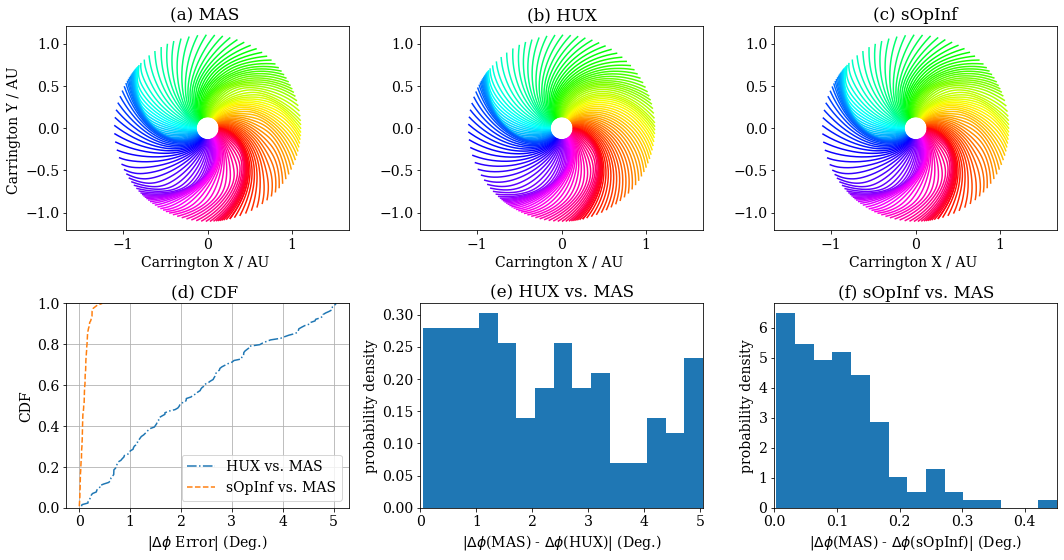

In [87]:
s_m = cmap()

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))
for ii in range(len(p)):
    _ = ax[0, 0].plot(np.cos(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 1].plot(np.cos(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 2].plot(np.cos(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    
_ = ax[0, 0].set_title("(a) MAS ")
_ = ax[0, 0].set_xlabel("Carrington X / AU ")
_ = ax[0, 0].set_ylabel("Carrington Y / AU ")
_ = ax[0, 0].axis("equal")

_ = ax[0, 1].set_title("(b) HUX")
_ = ax[0, 1].set_xlabel("Carrington X / AU ")
_ = ax[0, 1].axis("equal")

_ = ax[0, 2].set_title("(c) sOpInf")
_ = ax[0, 2].set_xlabel("Carrington X / AU ")
_ = ax[0, 2].axis("equal")

diff_hux = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_hux[-1])
mu, sigma = stats.norm.fit(diff_hux)
print("(HUX) mu = ", mu )
print("(HUX) median = ", np.median(np.abs(diff_hux)))
print("(HUX) max. = ", np.max(np.abs(diff_hux)))
print("(HUX) sigma = ", sigma )
n , bins, _ = ax[1, 1].hist(np.abs(diff_hux), 15, density=1)
_ = ax[1, 1].set_xlim(left=0, right=np.max(np.abs(diff_hux)))
_ = ax[1, 1].set_title("(e) HUX vs. MAS")
_ = ax[1, 1].set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(HUX)| (Deg.)")
_ = ax[1, 1].set_ylabel("probability density") 



diff_rom = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_sopinf[-1])
mu, sigma = stats.norm.fit(diff_rom)
print("(sOpInf) mu = ", mu )
print("(sOpInf) sigma = ", sigma )
print("(sOpInf) median = ", np.median(np.abs(diff_rom)))
print("(sOpInf) max. = ", np.max(np.abs(diff_rom)))
n , bins, _ = ax[1, 2].hist(np.abs(diff_rom), 15, density=1)
_ = ax[1, 2].set_xlim(left=0, right=np.max(np.abs(diff_rom)))
_ = ax[1, 2].set_title("(f) sOpInf vs. MAS")
_ = ax[1, 2].set_xlabel("$|\Delta \phi$(MAS) - $\Delta \phi$(sOpInf)| (Deg.)")
_ = ax[1, 2].set_ylabel("probability density") 


cdf(diff_hux, ax[1, 0], label = "HUX vs. MAS", ls="-.")
cdf(diff_rom, ax[1, 0], label = "sOpInf vs. MAS", ls="--")
ax[1, 0].set_ylim((0,1))
ax[1, 0].set_ylabel("CDF")
ax[1, 0].set_xlabel("|$\Delta \phi$ Error| (Deg.)")
ax[1, 0].grid(True)
ax[1, 0].set_title("(d) CDF ")
_ = ax[1, 0].legend()

plt.tight_layout()
plt.savefig("MHD/figs/CR" + str(cr) + "/H/MAS_HUX_sOpInf_H_streamlines.png")

### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [88]:
coeff_array = 10**np.linspace(5, 10, 20)
rank_array = np.arange(5, 10)

training_error = np.ones((len(coeff_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff_array), len(rank_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    for ii, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
        Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6) 
        model = roi.InferredContinuousROM(modelform="H")            
        model.fit(Vr, X_train, Xdot, P=coeff)                          
        X_ROM = model.predict(X[:, 0], r.value, method="BDF", 
                              max_step=(r_train[1] - r_train[0]).value) 
        
        if np.shape(X_ROM) == np.shape(V):
            V_ROM = convert_from_x_to_v(X_ROM)
            # save
            training_error[kk, ii] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
            # save
            testing_error[kk, ii] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

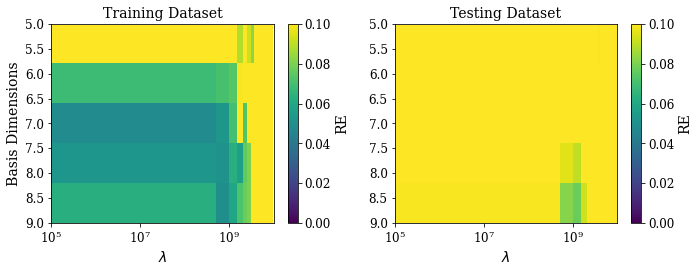

In [89]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].imshow(training_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0, vmax=0.1, aspect="auto")


_ = ax[0].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[0].set_ylabel(r"Basis Dimensions", fontsize=14)
_ = ax[0].set_title("Training Dataset", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('RE', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].imshow(testing_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0, vmax=0.1,   aspect="auto")


_ = ax[1].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[1].set_title("Testing Dataset", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('RE', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")

plt.tight_layout()

In [90]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Training rank =",  rank_array[idx[1]])

Training lambda = 5.0
Training rank = 7


In [91]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array[idx[1]])
print("Error =",  testing_error[idx[0], idx[1]])

Testing lambda = 5.526315789473684
Testing rank = 9
Error = 0.07769793688830642


### Quadratic + Linear ROM $\dot{\hat{\mathbf{u}}} = \mathbf{\hat{c}} + \mathbf{A} \hat{\mathbf{u}} + \mathbf{H} (\hat{\mathbf{u}} \otimes \hat{\mathbf{u}})$.

In [92]:
def regularizer(r, λ1, λ2, λ3=None):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    If λ3 is given, the entries of the cubic operator are penalized by λ3.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.
    λ2 : float or None
        Regularization hyperparameter for the cubic operator (if present).
    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r*(r + 1)//2
    if λ3 is None:
        diag𝚪 = np.full(r2+1, λ1)
        diag𝚪[r1:-1] = λ2
    else:
        r3 = r2 + r*(r + 1)*(r + 2)//6
        diag𝚪 = np.full(r3+1, λ1)
        diag𝚪[r1:r2] = λ2
        diag𝚪[r2:-1] = λ3
    return diag𝚪

In [93]:
rank=8

In [94]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="cAH")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=regularizer(rank, 5e6, 5e5))                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

In [95]:
V_ROM = convert_from_x_to_v(X_ROM)

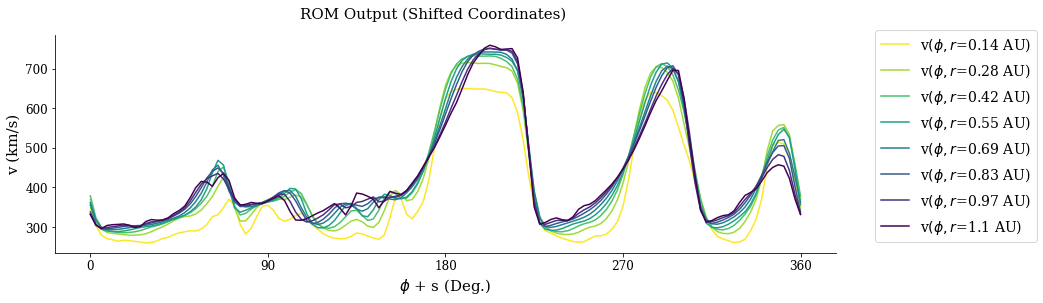

In [96]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel="$\phi$ + s (Deg.)")

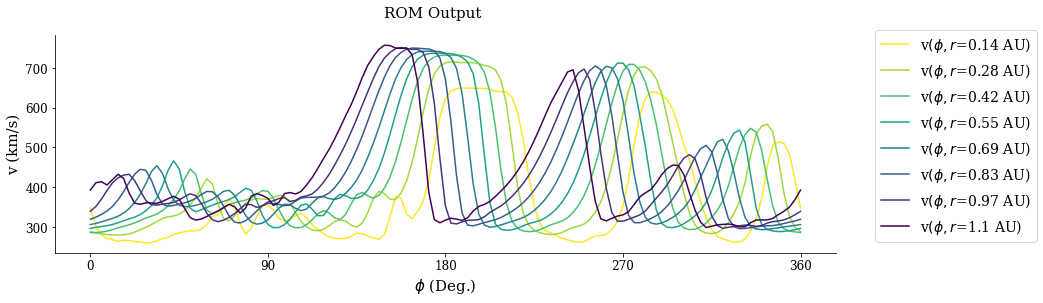

In [97]:
plot_heat_data(V_ROM, "ROM Output", variable="v")

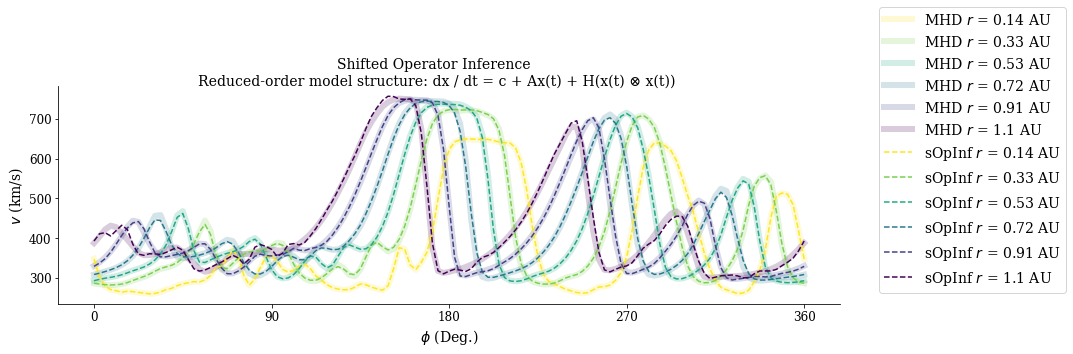

In [98]:

sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"MHD $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=rf"sOpInf $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=14)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("MHD/figs/CR" +str(cr) +"/cAH/sopinf_vs_mhd_cAH.png", dpi=500, bbox_inches='tight')

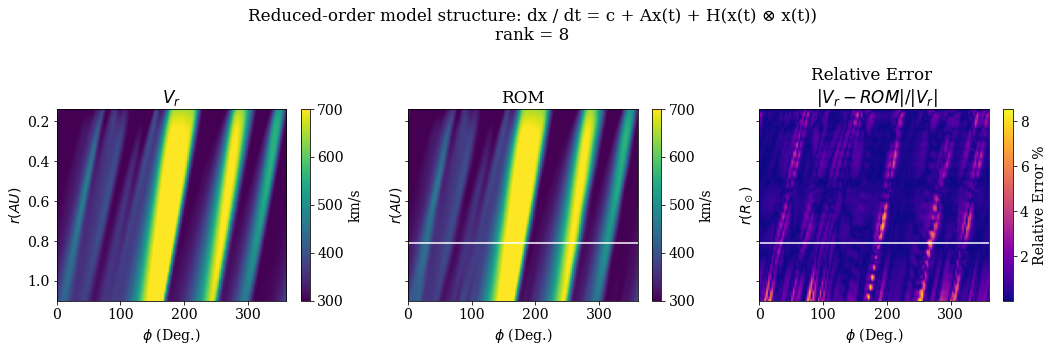

In [99]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360, r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360, r[-1].to(u.AU).value, 
                                    r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_ylabel(r"$r (AU)$")
ax[1].set_title("ROM")
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(100*np.abs(V_ROM.T - V.T)/np.abs(V.T), extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_ylabel(r"$r (R_\odot)$")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error %', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

fig.savefig("MHD/figs/CR" + str(cr) + "/cAH/shifted_HUX_relative_error_cAH.png", dpi=500, bbox_inches='tight')

In [100]:
print("training mean relative error = ", 100*np.mean(np.abs((V[:, :l]- V_ROM[:, :l]))/np.abs(V[:, :l])))
print("training median relative error = ", 100*np.median(np.abs((V[:, :l]- V_ROM[:, :l]))/np.abs(V[:, :l])))
print("training max relative error = ", 100*np.max(np.abs((V[:, :l]- V_ROM[:, :l]))/np.abs(V[:, :l])))

training mean relative error =  0.6314148490352408
training median relative error =  0.3837640198623643
training max relative error =  7.770401765636023


In [101]:
print("testing mean relative error = ", 100*np.mean(np.abs((V[:, l:]- V_ROM[:, l:]))/np.abs(V[:, l:])))
print("testing median relative error = ", 100*np.median(np.abs((V[:, l:]- V_ROM[:, l:]))/np.abs(V[:, l:])))
print("testing max relative error = ", 100*np.max(np.abs((V[:, l:]- V_ROM[:, l:]))/np.abs(V[:, l:])))

testing mean relative error =  0.8576816741368535
testing median relative error =  0.5126928241778463
testing max relative error =  8.55027421618161


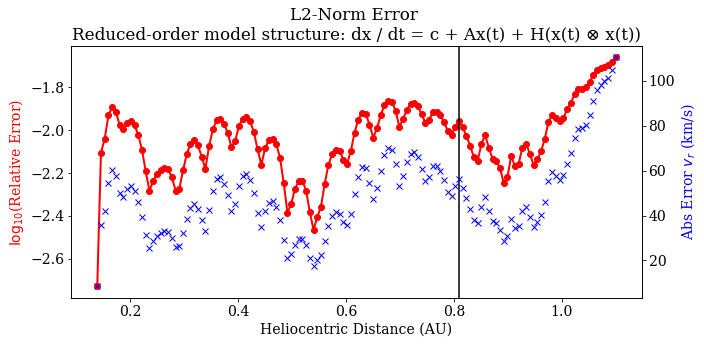

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errcAH),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error \n" + str(model))
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errcAH, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

plt.savefig("MHD/figs/CR" + str(cr) + "/cAH/L2_error.png", dpi=300)

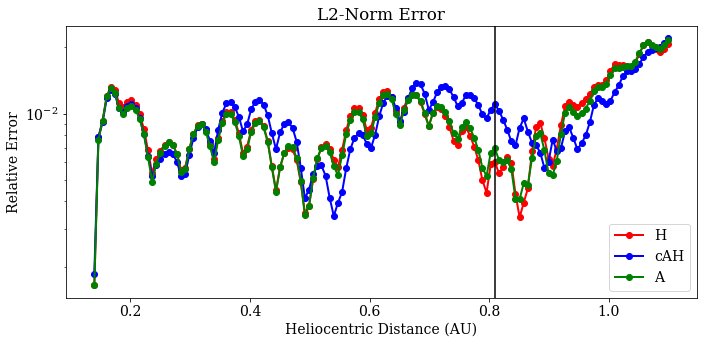

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))


_ = ax.plot(r.to(u.AU).value, rel_l2errH,"-o", linewidth=2, c="r", label="H")
_ = ax.plot(r.to(u.AU).value, rel_l2errcAH,"-o", linewidth=2, c="b", label="cAH")
_ = ax.plot(r.to(u.AU).value, rel_l2errA,"-o", linewidth=2, c="g", label="A")

_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error")
_ = ax.set_ylabel("Relative Error", c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.yscale("log")
plt.tight_layout()
plt.legend()

In [104]:
coeff1_array = 10**np.linspace(1, 10, 15)
coeff2_array = 10**np.linspace(1, 10, 15)
rank_array = np.arange(3, 10)

training_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * np.inf

for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        for ii, rank_r in enumerate(rank_array):
            Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
            Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6) 
            model = roi.InferredContinuousROM(modelform="cAH")            
            model.fit(Vr, X_train, Xdot, P=regularizer(rank_r, coeff1, coeff2))                          
            X_ROM = model.predict(X[:,  0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) 

            if np.shape(X_ROM) == np.shape(V):
                V_ROM = convert_from_x_to_v(X_ROM)
                # save
                training_error[kk, jj, ii] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
                # save
                testing_error[kk, jj, ii] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

In [105]:
idx  = np.unravel_index(training_error[:, :, :].argmin(), training_error[:, :, :].shape)
print("Training lambda1 =",  np.log10(coeff_array[idx[0]]))
print("Training lambda2 =",  np.log10(coeff_array[idx[1]]))
print("Training rank =",  rank_array[idx[2]])
print("RE = ",  training_error[idx])

Training lambda1 = 5.526315789473684
Training lambda2 = 6.315789473684211
Training rank = 7
RE =  0.042249419761526685


In [106]:
idx  = np.unravel_index(testing_error[:, :, :].argmin(), testing_error[:, :, :].shape)
print("Testing lambda1 =",  np.log10(coeff_array[idx[0]]))
print("Testing lambda2 =",  np.log10(coeff_array[idx[1]]))
print("Testing rank =",  rank_array[idx[2]])
print("RE = ",  training_error[idx])

Testing lambda1 = 5.526315789473684
Testing lambda2 = 6.842105263157895
Testing rank = 8
RE =  0.04855339918130704


# Sensitivity to Training Data

* **Test 1**: x training snapshots. 

* **Test 2**: x training snapshots. 

* **Test 3**: x training snapshots.

In [107]:
# initialize the training length. 
l1, l2, l3 = int(0.4*len(r)), int(0.55*len(r)), int(0.7*len(r))


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [108]:
r_train1 = r[:l1]
r_test1 = r[l1:-1]

r_train2 = r[:l2]
r_test2 = r[l2:-1]

r_train3 = r[:l3]
r_test3 = r[l3:-1]

In [109]:
# l1 = compute the results for quadradic with 3 modes.
rank=9
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1e2)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1)

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1e2)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2)

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1e2)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3)

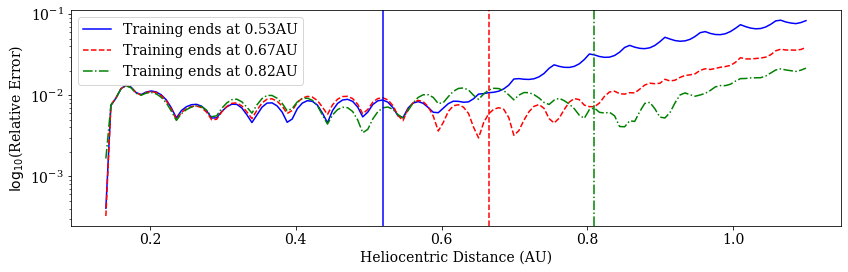

In [110]:
fig, ax = plt.subplots(figsize=(12, 4))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, V_ROM1)
_ = ax.plot(r.to(u.AU).value,rel_l2err1, "-", c="b", label="Training ends at " + str(round(r[l1].to(u.AU).value, 2)) + "AU")

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, V_ROM2)
_ = ax.plot(r.to(u.AU).value, rel_l2err2, "--", c="r", label="Training ends at " + str(round(r[l2].to(u.AU).value, 2)) + "AU")

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, V_ROM3)
_ = ax.plot(r.to(u.AU).value, rel_l2err3, "-.", c="g", label="Training ends at " + str(round(r[l3].to(u.AU).value, 2)) + "AU")

_ = ax.axvline(r_train1[-1].to(u.AU).value, linestyle="-", c="b")
_ = ax.axvline(r_train2[-1].to(u.AU).value, linestyle="--", c="r")
_ = ax.axvline(r_train3[-1].to(u.AU).value, linestyle="-.", c="g")
#_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_yscale("log")
plt.legend()
#plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()

plt.savefig("MHD/figs/CR2210/A/sensitivity_to_number_of_training_snapshots.png", dpi=300)